# Morpheus Deblend Discrete Directions Claim Vector Encoding Scheme

In this encoding scheme, we want to try fixing the claim vectors to be unit vectors according to their location in neighborhood and having the model predict the magnitude of the vector that puts the vector nearest to the source contributing light in that direction.

The hope is that using this scheme we can avoid the model learning to predict all claim vectors as pointing to the nearest source, creating the jigsaw effect we observed before.

The notebook is laid out as follows:

1. Getting the sample source and scarlet solution from the SCARLET quickstart guide
2. Morpheus Deblend Center Of Mass Code (Not Changed, Included for completeness)
3. Morpheus Deblend Claim Vector/Map Encoder
4. Morpheus Deblend Claim Vecotr/Map Decoder
4. Encode/Decode quickstart image and Visualize Results
5. Diff SCARLET/Morpheus Deblend and Visualize

## 1. Getting the sample source and scarlet solution from the SCARLET quickstart guide

In [3]:
# user guide from https://pmelchior.github.io/scarlet/0-quickstart.html
from functools import partial
from itertools import product, starmap
from  typing import Callable, List, Tuple

# Import Packages and setup
import numpy as np
import scarlet
import scarlet.psf as psf
import scarlet.display
from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', interpolation='none', origin='lower')
plt.style.use("robertsons_rules")

In [4]:
data = np.load("hsc_cosmos_35.npz")
images = data["images"] # (5, 58, 48)
filters = data["filters"] # ['g', 'r', 'i', 'z', 'y']
catalog = data["catalog"] # List of 2-Tuple, x and y
weights = 1/data["variance"] # (5, 58, 48)
psfs = scarlet.ImagePSF(data["psfs"]) # (5, 43, 43)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


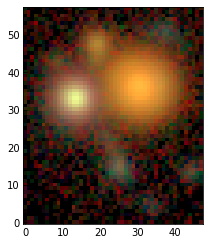

In [5]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)
plt.show()

In [6]:
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))

model_frame = scarlet.Frame(
    images.shape,
    psfs=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images,
    psfs=psfs,
    weights=weights,
    channels=filters).match(model_frame)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


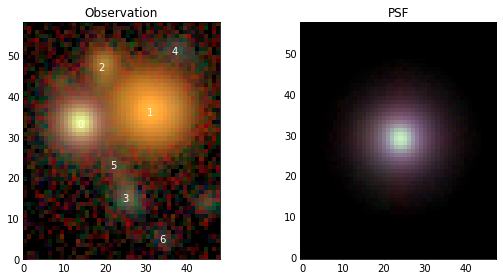

In [7]:
sky_coords = [[src['y'], src['x']] for src in catalog] # y/x!
scarlet.display.show_observation(observation, norm=norm, sky_coords=sky_coords, show_psf=True)
plt.show()

In [8]:
sources = []
for k,src in enumerate(catalog):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, (src['y'], src['x']), observation)
    elif k == 1:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, K=2)
    else:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, compact=True)
    sources.append(new_source)

CPU times: user 1.72 s, sys: 80.1 ms, total: 1.8 s
Wall time: 1.8 s
scarlet ran for 76 iterations to logL = 30420.93855546932


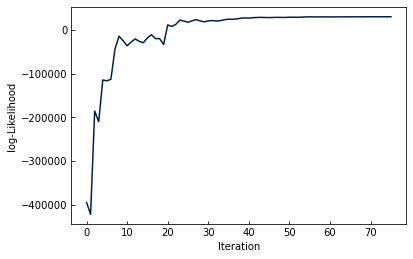

In [9]:
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(100, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

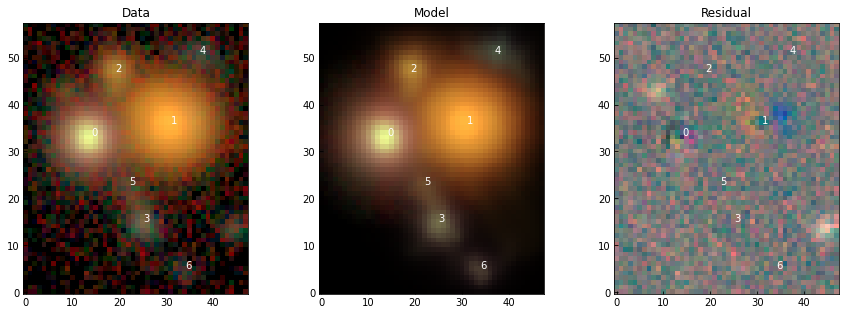

In [10]:
# Compute model
model = blend.get_model()
# Render it in the observed frame
model_ = observation.render(model)
# Compute residual
residual = images-model_

# each source rendered in each band
model_vals = [observation.render(sources[i].get_model(frame=sources[i].frame)) for i in range(len(sources))]

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,src in enumerate(blend):
    if hasattr(src, "center"):
        y,x = src.center
        ax[0].text(x, y, k, color="w")
        ax[1].text(x, y, k, color="w")
        ax[2].text(x, y, k, color="w")
plt.show()

## Morpheus Deblend Center Of Mass Code (Not Changed, Included for completeness)

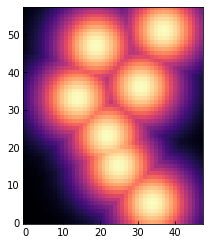

In [11]:
#https://stackoverflow.com/a/46892763/2691018
def gkern(kernlen=21, std=8):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

def generate_com(shape:Tuple[int, int], srcs:List[np.ndarray]) -> np.ndarray:
    gk_len = 51
    gk = gkern(gk_len, 8)
    
    com = np.zeros(shape, dtype=np.float32)
    height, width = shape
    for src in catalog:
        y, x = int(src["y"]), int(src["x"])
        half_len = int((gk_len / 2))
        

        big_ys = slice(
            max(y-half_len, 0),
            min(y+half_len, height)
        )
        
        big_xs = slice(
            max(x-half_len, 0),
            min(x+half_len, height)
        )
        
        g_ys = slice(
            half_len - min(half_len, half_len-(half_len-y)),
            half_len + min(half_len, height-y),
        )
        
        g_xs = slice(
            half_len - min(half_len, half_len-(half_len-x)),
            half_len + min(half_len, width-x),
        )
        
        b = com[big_ys, big_xs].copy()
        g = gk[g_ys, g_xs].copy()

        com[big_ys, big_xs] = np.maximum(g, b)

    return com

plt.imshow(generate_com(images.shape[1:], catalog))

## Morpheus Deblend Claim Vector/Map Encoder

### Claim Vector

The encoder function needs assign a magnitude for each pixel in a neighborhood of pixels, where each neighborhood pixel is assigned the unit vector in direction of the pixel from the pixel. For example, the neighborhood pixel to the right of a pixel would be assigned the vector \[0, 1\] and the neighborhood pixel below a pixel would be assigned the vector \[-1, 0\].

The magnitude value assigned to a neighborhood pixel is the scalar projection of vector representing the source's location relative to the pixel onto the vector representing the neighborhood pixel.

$$n_{\text{mag}} = \vec{s}\cdot\hat{n}$$

Where $n$ is the scalar magnitude value, $\vec{s}$ is the vector representing the source location relative to the center pixel, and $\hat{n}$ is the vector representing the neighbor pixel, which is a unit vector.

This representation is nice because it keeps claim vectors from reaching across the center pixel to what may be the nearest source and makes it easier to encourage a diverse set of sources associated with a pixel.

The next problem to solve is how to decide which source will assigned to a neighborhood pixel. After some iterating, I have found the following to work well:

$$\underset{\vec{s}}{\mathrm{argmax}} f(\vec{s}) = \text{cossim}(\vec{s}, \hat{n}) \times  (1 - \hat{\text{L}^2}(\vec{s}, \hat{n})) \times \hat{\text{F}}(\vec{s})$$

Where $\vec{s}$ is the vector representing the location of a source relative to the pixel we are cosidering, $\text{cossim}$ is the cosine similarity function, $\hat{n}$ is the vector representing the neighborhood pixel which is a unit vector, $\hat{\text{L}^2}(\cdot, \cdot)$ is a funtion that returns the l2 distance between $\hat{n}$ and $\vec{s}$ normalized by the distance to the furthest $\vec{s}$, and $\hat{\text{F}}(\cdot)$ is function that returns the source flux associated for a given $\vec{s}$ normalized by the maximum flux value contributed by all $\vec{s}$. This formulation is nice because is prioritizes sources that in the same direction as the neighborhood vector, nearby, and bright.

### Claim Map

The encoder function for the claim map assigns a scalar value \[0, 1] for each pixel in the neighborhood representing the amount of flux contributed to the center pixel by the source associated with the neighborhood pixel via the claim vector. This value is caluated as the following:

$$\text{F}_\hat{n} = \frac{\text{F}_{\vec{s}}}{\text{N}_{\vec{s}}\text{F}_\text{total}}$$

Where $\text{F}_\hat{n}$ is single value in the claim map representing a single neighborhood pixel $\hat{n}$, $\text{F}_{\vec{s}}$ is the flux from source $\vec{s}$ given by SCARLET, $\text{F}_{\text{total}}$ is the total flux in the center pixel according to SCARLET, and $\text{N}_{\vec{s}}$ is the number of neighborhood pixels source $\vec{s}$ is associated with.


In [28]:
neighborhood_vectors = np.array(list(product([0, -1, 1], [0, -1, 1]))[1:], dtype=np.float32)
neighborhood_vectors /= np.linalg.norm(neighborhood_vectors, axis=-1)[:, np.newaxis]

# Updates `claim_vector_magnitude` and `claim_map` in place
def get_claim_vector_magnitudes_single_pixel(
    claim_vector_magnitude:np.ndarray, 
    claim_map:np.ndarray, 
    model_vals:List[np.ndarray], 
    src_centers:np.ndarray, 
    y:int, 
    x:int, 
    b:int,
) -> None:
    relative_vectors = src_centers - np.array([y, x])
    src_fluxes = np.array([max(model_vals[i][b, y, x], 0) for i in range(len(model_vals))])
    normed_flux = src_fluxes / src_fluxes.max() # was sum
    normed_sum_to_one = src_fluxes / src_fluxes.sum()

    cosine_measure = cosine_similarity(neighborhood_vectors, relative_vectors)

    euclidean_distance = euclidean_distances(neighborhood_vectors, relative_vectors)
    normed_euclidean_distance = euclidean_distance / euclidean_distance.max(axis=1, keepdims=True)

    metric = cosine_measure * (1 - normed_euclidean_distance) * (normed_flux[np.newaxis, :])
    
    closest_srcs = np.argmax(metric, axis=1)
    selected_srcs = relative_vectors[closest_srcs, :]

    _claim_magnitudes = (selected_srcs * neighborhood_vectors).sum(axis=1)


    idxs, counts = np.unique(closest_srcs, return_counts=True)
    coefs = np.reciprocal(counts.astype(np.float32))
    _claim_map = np.array(list(map(lambda i: coefs[idxs==i][0] * normed_sum_to_one[i], closest_srcs)))    


    claim_vector_magnitude[y, x, b, :] = _claim_magnitudes
    claim_map[y, x, b, :] = _claim_map

def get_claim_vector_magnitude_map(
    model_vals:List[np.ndarray], 
    srcs_centers: np.ndarray, # [n,2]
) -> Tuple[np.ndarray, np.ndarray]: # ([h, w, b, 8], [h, w, b, 8])
    b, y, x = model_vals[0].shape
    
    idxs = product(range(y), range(x), range(b))

    claim_vector_magnitude = np.zeros([y, x, b, 8], dtype=np.float32)
    claim_map = np.zeros([y, x, b, 8], dtype=np.float32)

    encode_f = partial(get_claim_vector_magnitudes_single_pixel, claim_vector_magnitude, claim_map, model_vals, src_centers)

    for _ in starmap(encode_f, tqdm(idxs, total=y*x*b)):
        pass

    return claim_vector_magnitude, claim_map

In [29]:
src_centers = np.array([[c["y"], c["x"]] for c in catalog]) + 0.5 # offset source locations by 0.5 to avoid [0, 0] vectors
claim_vector_magnitude, claim_map = get_claim_vector_magnitude_map(model_vals, src_centers)

100%|██████████| 13920/13920 [00:08<00:00, 1715.40it/s]


## Morpheus Deblend Claim Vector/Map Decoder

The decoder has a much simpler task than the encoder. The decode, the output magntidudes are multiplied by the neighborhood vectors and then the claim map determines the amount of flux to assign to each source.

In [13]:
neighborhood_vectors = np.array(list(product([0, -1, 1], [0, -1, 1]))[1:], dtype=np.float32)
neighborhood_vectors /= np.linalg.norm(neighborhood_vectors, axis=-1)[:, np.newaxis]

def decode_single_pixel(
    output:np.ndarray,
    flux:np.ndarray, 
    claim_vector_magnitude:np.ndarray, 
    claim_map:np.ndarray, 
    src_centers:np.ndarray, 
    y:int, 
    x:int, 
    b:int
) -> None:
    pixel_flux = flux[y, x, b]
    pixel_magnitudes = claim_vector_magnitude[y, x, b, :].copy()
    pixel_claim_map = claim_map[y, x, b, :].copy()

    relative_vectors = neighborhood_vectors * pixel_magnitudes[:, np.newaxis]
    relative_centers = src_centers - np.array([y, x])

    distances = euclidean_distances(relative_vectors, relative_centers) # [n_neighborhood, n_centers]
    closest_src = np.argmin(distances, axis=1)

    distributed_flux = pixel_flux * pixel_claim_map

    def update_output(src_idx:int, flx:float):
        output[src_idx, y, x, b] += flx

    for _ in starmap(update_output, zip(closest_src, distributed_flux)):
        pass

def decode(
    flux:np.ndarray, 
    claim_vector_magnitude:np.ndarray, 
    claim_map:np.ndarray, 
    src_centers:np.ndarray
) -> np.ndarray:
    y, x, b = flux.shape
    output = np.zeros([src_centers.shape[0], y, x, b], dtype=np.float32)

    idxs = product(range(y), range(x), range(b))

    decode_f = partial(decode_single_pixel, output, flux, claim_vector_magnitude, claim_map, src_centers)

    for _ in starmap(decode_f, tqdm(idxs, total=y*x*b)):
        pass

    return output

## Encode/Decode quickstart image and Visualize Results

The first plot is linear and the second one is log. 

Though there is some noise, this method shows promise in that sources have overlapping pixel ownership, which we really need and was lacking before. 

In [24]:
src_centers = np.array([[c["y"], c["x"]] for c in catalog]) + 0.5 # offset source locations by 0.5 to avoid [0, 0] vectors
claim_vector_magnitude, claim_map = get_claim_vector_magnitude_map(model_vals, src_centers)

flux = np.transpose(images, axes=(1,2,0))
output = decode(flux, claim_vector_magnitude, claim_map, src_centers)

100%|██████████| 13920/13920 [00:02<00:00, 6059.59it/s]


(0.0, 1.0, 0.0, 1.0)

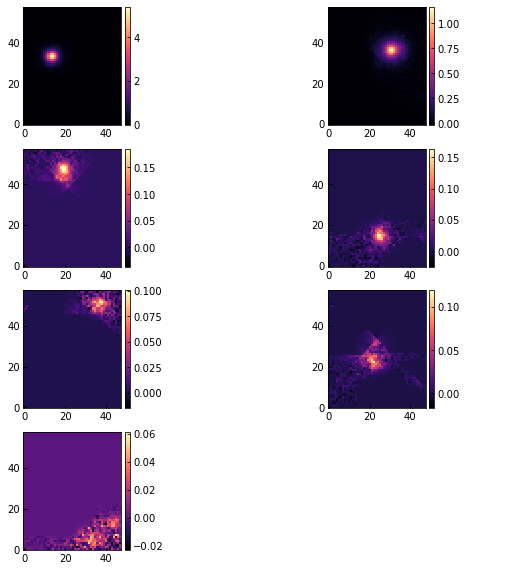

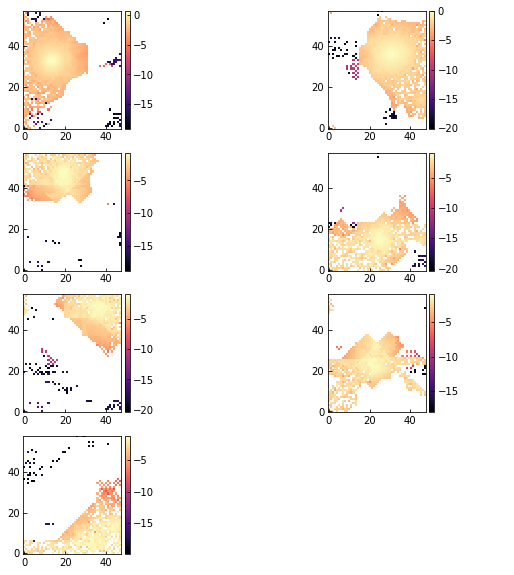

In [26]:
band = 0

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i, ax in zip(range(output.shape[0]), axes.flat):
    im = ax.imshow(output[i, :, :, band])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1][-1].axis("off")

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i, ax in zip(range(output.shape[0]), axes.flat):
    im = ax.imshow(np.log10(output[i, :, :, band]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1][-1].axis("off")

## Diff SCARLET/Morpheus Deblend and Visualize

Diffed source-by-source, then total images diffed.

(0.0, 1.0, 0.0, 1.0)

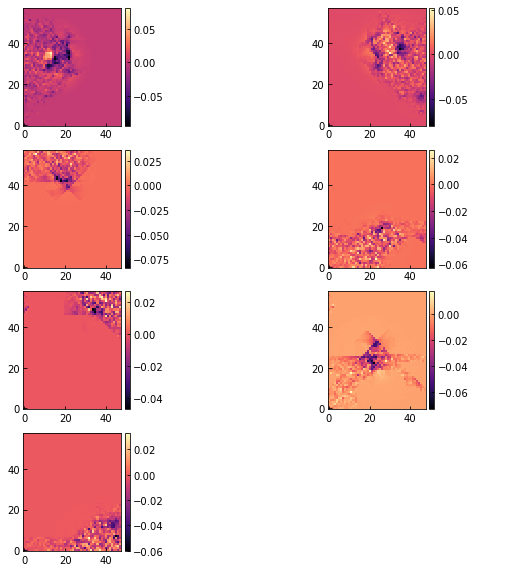

In [27]:
band = 0

f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i, ax in zip(range(output.shape[0]), axes.flat):
    im = ax.imshow(model_vals[i][band, :, :] - output[i, :, :, band])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

axes[-1][-1].axis("off")

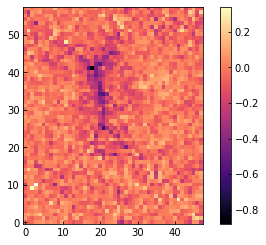

In [15]:
band = 4
plt.imshow(sum(model_vals)[band, :, :] - output.sum(axis=0)[:, :, band])
plt.colorbar()